# Simple audio recognition: Recognizing keywords

This tutorial demonstrates how to preprocess audio files in the WAV format and build and train a basic automatic speech recognition (ASR) model for recognizing ten different words. You will use a portion of the [Speech Commands dataset (Warden, 2018)](https://arxiv.org/abs/1804.03209), which contains short (one-second or less) audio clips of commands, such as "down", "go", "left", "no", "right", "stop", "up" and "yes".

Real-world speech and audio recognition systems are complex. But, like image classification with the MNIST dataset, this tutorial should give you a basic understanding of the techniques involved.

[Reference](https://www.tensorflow.org/tutorials/audio/simple_audio)

In [ ]:
# Specify GPU to be used-
# %env CUDA_DEVICE_ORDER = PCI_BUS_ID
# %env CUDA_VISIBLE_DEVICES = 0

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import AveragePooling2D, Conv2D, MaxPooling2D, ReLU
from tensorflow.keras import models, layers, datasets
from tensorflow.keras.layers import Dense, Flatten, Reshape, Input, InputLayer, Resizing
from tensorflow.keras.layers import Layer, Dropout, BatchNormalization, Activation, Normalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.initializers import RandomNormal, Constant
from tensorflow.keras import regularizers
import tensorflow.keras.backend as K

from IPython import display
import os
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
print(f"TensorFlow version: {tf.__version__}")

TensorFlow version: 2.8.0


In [3]:
# Check GPU availibility-
gpu_devices = tf.config.list_physical_devices('GPU')
# print(f"GPU: {gpu_devices}")

if gpu_devices:
    print(f"GPU: {gpu_devices}")
    details = tf.config.experimental.get_device_details(gpu_devices[0])
    print(f"GPU details: {details.get('device_name', 'Unknown GPU')}")
else:
    print("No GPU found")

No GPU found


The dataset's audio clips are stored in eight folders corresponding to each speech command: ```no```, ```yes```, ```down```, ```go```, ```left```, ```up```, ```right```, and ```stop```.

In [4]:
DATASET_PATH = '../Downloads/mini_speech_commands'
data_dir = pathlib.Path(DATASET_PATH)

In [5]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[commands != 'README.md']
print('Commands:', commands)

Commands: ['down' 'go' 'left' 'no' 'right' 'stop' 'up' 'yes']


In [6]:
# Extract the audio clips into a list called filenames, and shuffle it-
filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)

In [7]:
type(filenames)

tensorflow.python.framework.ops.EagerTensor

In [8]:
print(f'Number of total examples = {num_samples}')
print(f'Number of examples per label = {len(tf.io.gfile.listdir(str(data_dir/commands[0])))}')
print(f'Example file tensor: {filenames[0]}')

Number of total examples = 8000
Number of examples per label = 1000
Example file tensor: b'..\\Downloads\\mini_speech_commands\\left\\b52bd596_nohash_0.wav'


In [9]:
# Split 'filenames' into training, validation and test sets using a 80:10:10 ratio, respectively-
train_files = filenames[:6400]
val_files = filenames[6400: 6400 + 800]
test_files = filenames[-800:]

In [10]:
print(f'Training set size = {len(train_files)}, Validation set size = '
      f'{len(val_files)} & Test set size = {len(test_files)}')

Training set size = 6400, Validation set size = 800 & Test set size = 800


### Read the audio files and their labels

Here, we will preprocess the dataset, creating decoded tensors for the waveforms and the corresponding labels. Note that:

- Each WAV file contains time-series data with a set number of samples per second.

- Each sample represents the [amplitude](https://en.wikipedia.org/wiki/Amplitude) of the audio signal at that specific time.

- In a [16-bit](https://en.wikipedia.org/wiki/Audio_bit_depth) system, like the WAV files in the mini Speech Commands dataset, the amplitude values range from -32,768 to 32,767.

- The [sample rate](https://en.wikipedia.org/wiki/Sampling_(signal_processing)#Audio_sampling) for this dataset is 16kHz.

The shape of the tensor returned by ```tf.audio.decode_wav``` is [samples, channels], where __```channels``` is ```1``` for mono or, ```2``` for stereo__. The mini Speech Commands dataset only contains mono recordings. 

In [11]:
test_file = tf.io.read_file(DATASET_PATH + '/down/0a9f9af7_nohash_0.wav')
test_audio, _ = tf.audio.decode_wav(contents = test_file)
test_audio.shape

TensorShape([13654, 1])

In [12]:
def decode_audio(audio_binary):
    '''
    Function to preprocesses the dataset's raw WAV audio files into audio tensors.
    '''
    # Decode WAV-encoded audio files to `float32` tensors, normalized
    # to the [-1.0, 1.0] range. Return `float32` audio and a sample rate.
    audio, _ = tf.audio.decode_wav(contents = audio_binary)
    
    # For this dataset, all of it is single channel (mono), so drop the `channels`
    # axis from the array.
    return tf.squeeze(audio, axis = -1)


Define a function that creates labels using the parent directories for each file:

- Split the file paths into ```tf.RaggedTensors``` (tensors with ragged dimensions—with slices that may have different lengths).

In [13]:
def get_label(file_path):
    parts = tf.strings.split(
        input = file_path,
        sep = os.path.sep)
    # Note: You'll use indexing here instead of tuple unpacking to enable this
    # to work in a TensorFlow graph.
    return parts[-2]


In [14]:
def get_waveform_and_label(file_path):
    '''
    Function to put it all together:
    1. The input is the WAV audio filename.
    2. The output is a tuple containing the audio and label tensors ready for supervised learning.
    '''
    label = get_label(file_path)
    audio_binary = tf.io.read_file(file_path)
    waveform = decode_audio(audio_binary)
    return waveform, label


### Build the training set to extract the audio-label pairs:

- Create a ```tf.data.Dataset``` with ```Dataset.from_tensor_slices``` and ```Dataset.map```, using ```get_waveform_and_label()``` defined earlier.

You'll build the validation and test sets using a similar procedure later on.

In [15]:
AUTOTUNE = tf.data.AUTOTUNE

files_ds = tf.data.Dataset.from_tensor_slices(train_files)

waveform_ds = files_ds.map(
    map_func = get_waveform_and_label,
    num_parallel_calls = AUTOTUNE
)

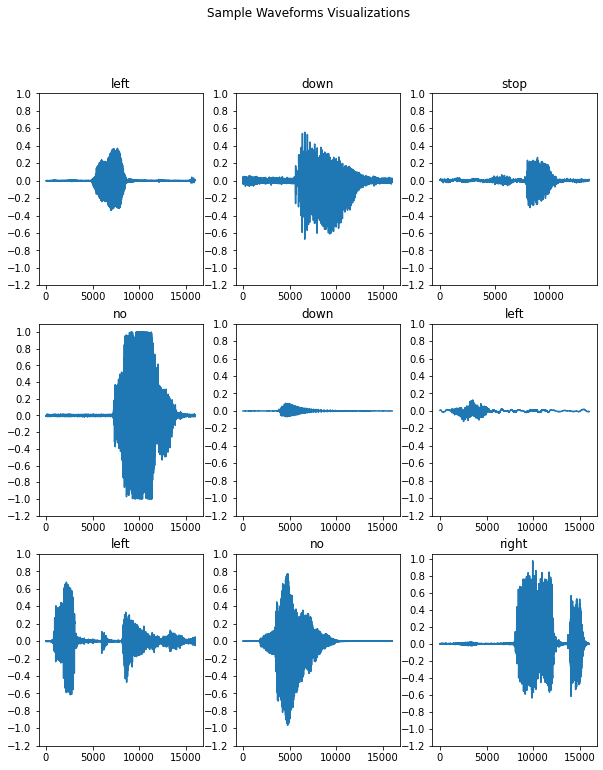

In [16]:
# Visualize some sample waveforms-
rows = 3
cols = 3
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize = (10, 12))

for i, (audio, label) in enumerate(waveform_ds.take(n)):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    ax.plot(audio.numpy())
    ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
    label = label.numpy().decode('utf-8')
    ax.set_title(label)

plt.suptitle("Sample Waveforms Visualizations")
plt.show()

### Convert waveforms to spectrograms

The waveforms in the dataset are represented in the time domain. Next, you'll transform the waveforms from the time-domain signals into the time-frequency-domain signals by computing the [short-time Fourier transform (STFT)](https://en.wikipedia.org/wiki/Short-time_Fourier_transform) to convert the waveforms to as [spectrograms](https://en.wikipedia.org/wiki/Spectrogram), which show frequency changes over time and can be represented as 2D images. You will feed the spectrogram images into your neural network to train the model.

A Fourier transform ([tf.signal.fft](https://www.tensorflow.org/api_docs/python/tf/signal/fft)) converts a signal to its component frequencies, but loses all time information. In comparison, STFT ([tf.signal.stft](https://www.tensorflow.org/api_docs/python/tf/signal/stft)) splits the signal into windows of time and runs a Fourier transform on each window, preserving some time information, and returning a 2D tensor that you can run standard convolutions on.

Create a utility function for converting waveforms to spectrograms:

- The waveforms need to be of the same length, so that when you convert them to spectrograms, the results have similar dimensions. This can be done by simply zero-padding the audio clips that are shorter than one second (using [tf.zeros](https://www.tensorflow.org/api_docs/python/tf/zeros)).

- When calling [tf.signal.stft](https://www.tensorflow.org/api_docs/python/tf/signal/stft), choose the ```frame_length``` and ```frame_step``` parameters such that the generated spectrogram "image" is almost square. For more information on the STFT parameters choice, refer to [this Coursera video](https://www.coursera.org/lecture/audio-signal-processing/stft-2-tjEQe) on audio signal processing and STFT.

- The STFT produces an array of complex numbers representing magnitude and phase. However, in this tutorial you'll only use the magnitude, which you can derive by applying [tf.abs](https://www.tensorflow.org/api_docs/python/tf/math/abs) on the output of [tf.signal.stft](https://www.tensorflow.org/api_docs/python/tf/signal/stft).

In [17]:
def get_spectrogram(waveform):
    # Zero-padding for an audio waveform with less than 16,000 samples-
    input_len = 16000
    waveform = waveform[:input_len]
    zero_padding = tf.zeros(
        [16000] - tf.shape(waveform),
        dtype = tf.float32)
    
    # Cast the waveform tensors' dtype to float32-
    waveform = tf.cast(waveform, dtype=tf.float32)
    
    # Concatenate the waveform with `zero_padding`, which ensures all audio
    # clips are of the same length-
    equal_length = tf.concat([waveform, zero_padding], 0)
    
    # Convert the waveform to a spectrogram via a STFT-
    spectrogram = tf.signal.stft(
        equal_length, frame_length = 255, frame_step = 128
    )
    
    # Obtain the magnitude of the STFT-
    spectrogram = tf.abs(spectrogram)
    
    # Add a `channels` dimension, so that the spectrogram can be used
    # as image-like input data with convolution layers (which expect
    # shape (`batch_size`, `height`, `width`, `channels`).
    spectrogram = spectrogram[..., tf.newaxis]
    
    return spectrogram


Now, start exploring the data. Print the shapes of one example's tensorized waveform and the corresponding spectrogram, and play the original audio-

In [18]:
for waveform, label in waveform_ds.take(1):
    label = label.numpy().decode('utf-8')
    spectrogram = get_spectrogram(waveform)

In [19]:
print(f'Label = {label}')
print(f'Waveform shape: {waveform.shape} & Spectrogram shape: {spectrogram.shape}')

Label = left
Waveform shape: (16000,) & Spectrogram shape: (124, 129, 1)


In [20]:
print('Audio playback')
display.display(display.Audio(waveform, rate = 16000))

Audio playback


In [21]:
def plot_spectrogram(spectrogram, ax):
    '''
    Function to display a spectrogram.
    '''
    if len(spectrogram.shape) > 2:
        assert len(spectrogram.shape) == 3
        spectrogram = np.squeeze(spectrogram, axis=-1)
    
    # Convert the frequencies to log scale and transpose, so that the time is
    # represented on the x-axis (columns).
    # Add an epsilon to avoid taking a log of zero-
    log_spec = np.log(spectrogram.T + np.finfo(float).eps)
    height = log_spec.shape[0]
    width = log_spec.shape[1]
    X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
    Y = range(height)
    ax.pcolormesh(X, Y, log_spec)
    
    return None


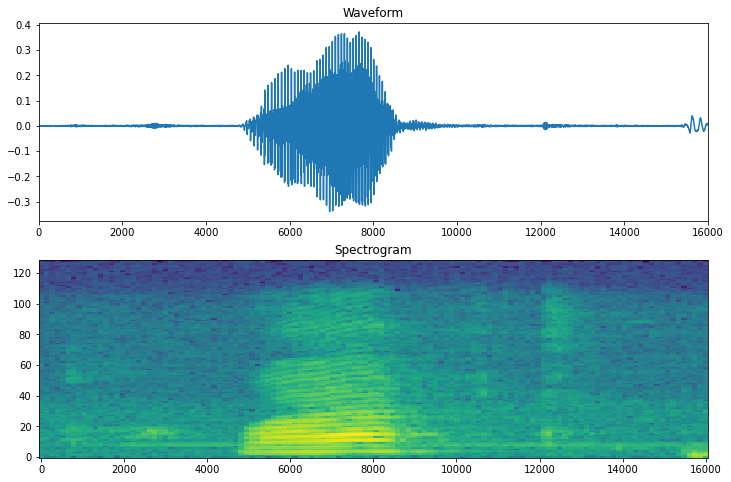

In [22]:
# Plot the example's waveform over time and the corresponding spectrogram (frequencies over time)-

fig, axes = plt.subplots(2, figsize = (12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.show()

In [23]:
def get_spectrogram_and_label_id(audio, label):
    '''
    Function that transforms the waveform dataset into spectrograms
    and their corresponding labels as integer IDs.
    '''
    spectrogram = get_spectrogram(audio)
    label_id = tf.math.argmax(label == commands)
    return spectrogram, label_id


In [24]:
# Map 'get_spectrogram_and_label_id()' across the dataset's elements with 'Dataset.map'-
spectrogram_ds = waveform_ds.map(
    map_func = get_spectrogram_and_label_id,
    num_parallel_calls = AUTOTUNE
)

In [25]:
type(spectrogram_ds)

tensorflow.python.data.ops.dataset_ops.ParallelMapDataset

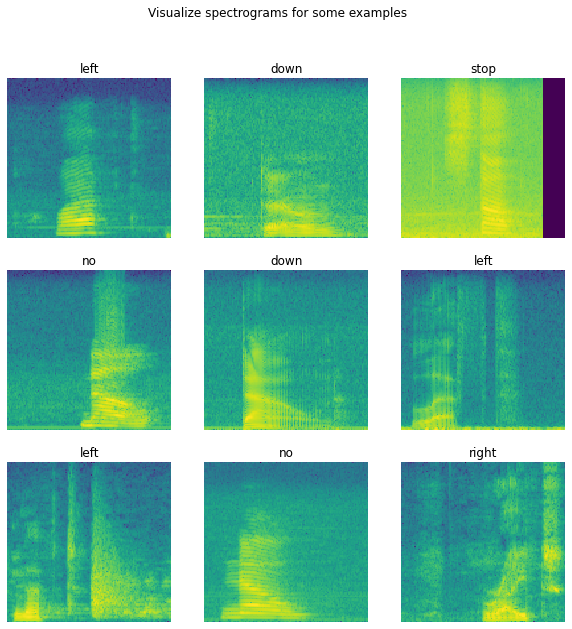

In [26]:
# Examine the spectrograms for different examples of the dataset-

rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize = (10, 10))

for i, (spectrogram, label_id) in enumerate(spectrogram_ds.take(n)):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(spectrogram.numpy(), ax)
    ax.set_title(commands[label_id.numpy()])
    ax.axis('off')

plt.suptitle("Visualize spectrograms for some examples")
plt.show()

Repeat the training set preprocessing on the validation and test sets:

In [27]:
def preprocess_dataset(files):
    files_ds = tf.data.Dataset.from_tensor_slices(files)
    output_ds = files_ds.map(
        map_func = get_waveform_and_label,
      num_parallel_calls = AUTOTUNE
    )
    output_ds = output_ds.map(
        map_func = get_spectrogram_and_label_id,
        num_parallel_calls = AUTOTUNE
    )
    
    return output_ds


In [28]:
train_ds = spectrogram_ds
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)

In [29]:
# Batch the training and validation sets for model training0
batch_size = 256

train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

In [30]:
# Add 'Dataset.cache' and 'Dataset.prefetch' operations to reduce read
# latency while training the model-
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

In [31]:
for spectrogram, _ in spectrogram_ds.take(1):
    input_shape = spectrogram.shape
    
num_labels = len(commands)
print(f'Input shape: {input_shape} & number of labels = {num_labels}')

Input shape: (124, 129, 1) & number of labels = 8


In [32]:
weight_decay = 5e-4

### Define CNN architecture for supervised classification

In [33]:
class CNN_Model(Model):
    def __init__(self, inputshape):
        super(CNN_Model, self).__init__()
        self.inputshape = inputshape
        
        # self.input_layer = Input(shape = self.inputshape)
        
        # Downsample the input-
        self.resize = Resizing(32, 32)
        
        '''
        For the 'Normalization' layer, its 'adapt()' method would first
        need to be called on the training data in order to compute aggregate
        statistics (that is, the mean and the standard deviation).
        '''
        # Instantiate the `tf.keras.layers.Normalization` layer-
        self.norm_layer = Normalization()
        # Fit the state of the layer to the spectrograms
        # with `Normalization.adapt`-
        self.norm_layer.adapt(data = spectrogram_ds.map(
            map_func = lambda spec, label: spec
        )
                             )
        
        self.conv1 = Conv2D(
            filters = 32, kernel_size = (3, 3),
            activation = None, kernel_initializer = tf.initializers.he_normal(),
            strides = (1, 1), padding = 'same',
            use_bias = True, kernel_regularizer = regularizers.l2(weight_decay)
        )
        self.conv2 = Conv2D(
            filters = 64, kernel_size = (3, 3),
            activation = None, kernel_initializer = tf.initializers.he_normal(),
            strides = (1, 1), padding = 'same',
            use_bias = True, kernel_regularizer = regularizers.l2(weight_decay)
        )
        self.dropout = Dropout(rate = 0.2)
        self.maxpool = MaxPooling2D()
        self.flatten = Flatten()
        self.dense = Dense(units = 128, activation = None)
        self.output_layer = Dense(units = num_labels, activation = None)
        
    
    def call(self, x):
        # x = self.input_layer()(x)
        x = self.resize(x)
        x = self.norm_layer(x)
        x = tf.nn.relu(self.conv1(x))
        x = self.dropout(tf.nn.relu(self.conv2(x)))
        x = self.maxpool(x)
        x = self.flatten(x)
        x = self.dropout(tf.nn.relu(self.dense(x)))
        x = self.output_layer(x)
        return x
    
    
    def shape_computation(self, x):
        print(f"Input shape: {x.shape}")
        x = self.resize(x)
        print(f"Resized output shape: {x.shape}")
        x = self.norm_layer(x)
        print(f"Normalized output shape: {x.shape}")
        
        return None
        
        

In [37]:
# Instantiate an instance of CNN architecture-
model = CNN_Model(inputshape = input_shape)

In [ ]:
# model.build(input_shape = input_shape)
# model.summary()

In [38]:
# Compile defined model-
model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
    metrics = ['accuracy']
)

In [39]:
# Train model for just 10 epochs-
EPOCHS = 10

history = model.fit(
    train_ds, validation_data = val_ds,
    epochs = EPOCHS,
    callbacks = tf.keras.callbacks.EarlyStopping(
        verbose = 1, patience = 2,
        monitor = 'val_accuracy', mode = 'max',
        restore_best_weights = True
    )
)

Epoch 1/10
25/25 [==============================] - 9s 363ms/step - loss: 2.8176 - accuracy: 0.1819 - val_loss: 2.0981 - val_accuracy: 0.2138
Epoch 2/10
25/25 [==============================] - 12s 498ms/step - loss: 2.0104 - accuracy: 0.2534 - val_loss: 1.9130 - val_accuracy: 0.3162
Epoch 3/10
25/25 [==============================] - 12s 480ms/step - loss: 1.8075 - accuracy: 0.3559 - val_loss: 1.6709 - val_accuracy: 0.4750
Epoch 4/10
25/25 [==============================] - 12s 464ms/step - loss: 1.5512 - accuracy: 0.4614 - val_loss: 1.3992 - val_accuracy: 0.5962
Epoch 5/10
25/25 [==============================] - 12s 466ms/step - loss: 1.3331 - accuracy: 0.5620 - val_loss: 1.2096 - val_accuracy: 0.6575
Epoch 6/10
25/25 [==============================] - 12s 464ms/step - loss: 1.1195 - accuracy: 0.6370 - val_loss: 1.0707 - val_accuracy: 0.7063
Epoch 7/10
25/25 [==============================] - 12s 465ms/step - loss: 0.9781 - accuracy: 0.6866 - val_loss: 0.9478 - val_accuracy: 0.7312


In [40]:
# Save trained model-
model.save_weights("CNN_Trained_Voice_Recognition.h5", overwrite = True)

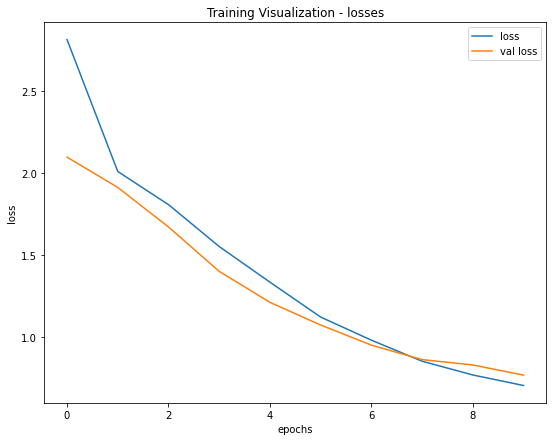

In [42]:
# Visualize training losses-
plt.figure(figsize = (9, 7))
plt.plot(history.history['loss'], label = 'loss')
plt.plot(history.history['val_loss'], label = 'val loss')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("Training Visualization - losses")
plt.legend(loc = 'best')
plt.show()

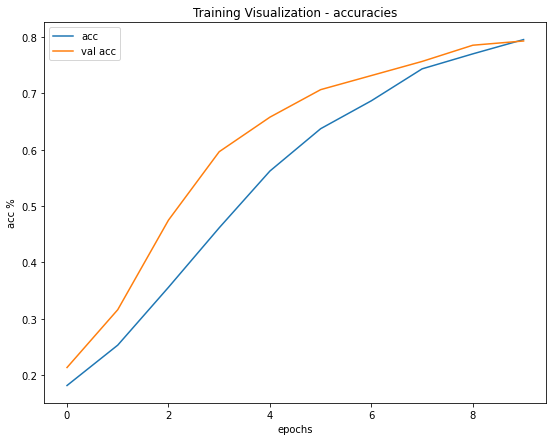

In [45]:
# Visualize training accuracies-
plt.figure(figsize = (9, 7))
plt.plot(history.history['accuracy'], label = 'acc')
plt.plot(history.history['val_accuracy'], label = 'val acc')
plt.xlabel("epochs")
plt.ylabel("acc %")
plt.title("Training Visualization - accuracies")
plt.legend(loc = 'best')
plt.show()

### Evaluate the model performance:

Run the model on the test set to check trained model's performance.

In [46]:
test_audio = []
test_labels = []

for audio, label in test_ds:
    test_audio.append(audio.numpy())
    test_labels.append(label.numpy())

# Convert to np arrays-
test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

In [47]:
test_audio.shape, test_labels.shape

((800, 124, 129, 1), (800,))

In [49]:
# Get model's test dataset performance-
y_pred = np.argmax(model.predict(test_audio), axis = 1)
y_true = test_labels

In [53]:
# Compute test accuracy-
test_acc = sum(y_pred == y_true) / len(y_true) * 100
print(f'Test set accuracy: {test_acc:.3f}%')

Test set accuracy: 75.750%


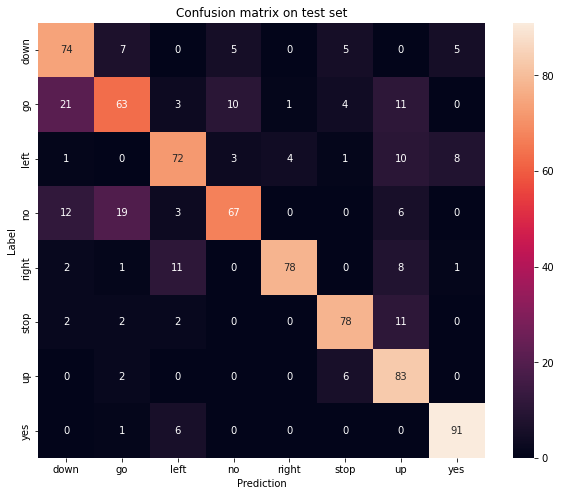

In [54]:
# Visualize confusion matrix for all labels-
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize = (10, 8))
sns.heatmap(confusion_mtx,
            xticklabels = commands,
            yticklabels = commands,
            annot = True, fmt = 'g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.title("Confusion matrix on test set")
plt.show()

### Run inference on an audio file

Finally, verify the model's prediction output using an input audio file of someone saying "no". How well does the trained model perform?

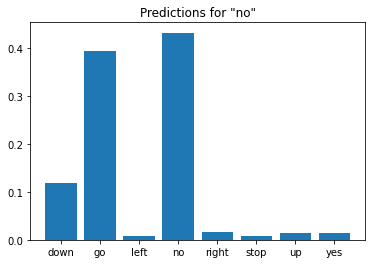

In [55]:
sample_file = data_dir/'no/01bb6a2a_nohash_0.wav'

sample_ds = preprocess_dataset([str(sample_file)])

for spectrogram, label in sample_ds.batch(1):
    prediction = model(spectrogram)
    plt.bar(commands, tf.nn.softmax(prediction[0]))
    plt.title(f'Predictions for "{commands[label[0]]}"')
    plt.show()

### Next steps

This tutorial demonstrated how to carry out simple audio classification/automatic speech recognition using a convolutional neural network with TensorFlow and Python. To learn more, consider the following resources:

- The [Sound classification with YAMNet](https://www.tensorflow.org/hub/tutorials/yamnet) tutorial shows how to use transfer learning for audio classification.

- The notebooks from [Kaggle's TensorFlow speech recognition challenge](https://www.kaggle.com/c/tensorflow-speech-recognition-challenge/overview).

- The [TensorFlow.js - Audio recognition using transfer learning codelab](https://codelabs.developers.google.com/codelabs/tensorflowjs-audio-codelab/index.html#0) teaches how to build your own interactive web app for audio classification.

- A [tutorial on deep learning for music information retrieval](https://arxiv.org/abs/1709.04396) (Choi et al., 2017) on arXiv.

- TensorFlow also has additional support for [audio data preparation and augmentation](https://www.tensorflow.org/io/tutorials/audio) to help with your own audio-based projects.

- Consider using the [librosa](https://librosa.org/) library—a Python package for music and audio analysis.